In [6]:
!pip install mediapipe pillow torch torchvision diffusers opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 10.2 MB/s eta 0:00

In [1]:
import os
from PIL import Image
import torch
from dataclasses import dataclass
from typing import Tuple, Union
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.models.modeling_utils import ModelMixin
from diffusers.utils import BaseOutput
from torchvision.models.resnet import BasicBlock

# ------------------ MODEL DEFINITIONS ------------------
@dataclass
class HeadSegmentationModelOutput(BaseOutput):
    sample: torch.Tensor

class SimpleResNetEncoder(nn.Module):
    def __init__(self, out_channels, depth=5, in_channels=3):
        super().__init__()
        self._depth = depth
        self._out_channels = out_channels
        self._in_channels = in_channels
        # Define layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._in_channels = 64
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self._in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = [BasicBlock(self._in_channels, out_channels, stride, downsample)]
        self._in_channels = out_channels
        layers.extend(BasicBlock(out_channels, out_channels) for _ in range(1, blocks))
        return nn.Sequential(*layers)

    def get_stages(self):
        return [
            nn.Sequential(self.conv1, self.bn1, self.relu),
            nn.Sequential(self.maxpool, self.layer1),
            self.layer2,
            self.layer3,
            self.layer4,
        ]

    def forward(self, x):
        stages = self.get_stages()
        features = [x]
        for i in range(len(stages)):
            x = stages[i](x)
            features.append(x)
        return features

class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        relu = nn.ReLU(inplace=True)
        bn = nn.BatchNorm2d(out_channels)
        super(Conv2dReLU, self).__init__(conv, bn, relu)

class SegmentationHead(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, upsampling=1
    ):
        conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        upsampling = (
            nn.UpsamplingBilinear2d(scale_factor=upsampling)
            if upsampling > 1
            else nn.Identity()
        )
        super().__init__(conv2d, upsampling)

class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
    ):
        super().__init__()
        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )
        encoder_channels = encoder_channels[1:]
        encoder_channels = encoder_channels[::-1]
        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels
        self.center = nn.Identity()
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):
        features = features[1:]
        features = features[::-1]
        head = features[0]
        skips = features[1:]
        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)
        return x

class HeadSegmentationModel(ModelMixin, ConfigMixin):
    @register_to_config
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 2,
        encoder_depth: int = 5,
        input_resolution: int = 512,
    ):
        super().__init__()
        block_out_channels = (3, 64, 64, 128, 256, 512)
        self.encoder = SimpleResNetEncoder(
            out_channels=block_out_channels,
            depth=encoder_depth,
            in_channels=in_channels
        )
        decoder_channels = [input_resolution // (2 ** i) for i in range(encoder_depth)]
        self.decoder = UnetDecoder(
            encoder_channels=block_out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth
        )
        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=out_channels,
            kernel_size=3,
        )

    def forward(self, x: torch.Tensor) -> Union[Tuple[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        """Sequentially pass `x` through model's encoder, decoder and heads"""
        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        masks = self.segmentation_head(decoder_output)
        return HeadSegmentationModelOutput(sample=masks)

class HeadSegmentationPipeline:
    def __init__(self, model_name_or_path: str, device: torch.device = torch.device('cpu')):
        self.device = device
        self.model = HeadSegmentationModel.from_pretrained(model_name_or_path)
        self.model.to(self.device)
        self.model.eval()

    def preprocess(self, image: Image.Image) -> torch.Tensor:
        image = image.convert("RGB")
        image = image.resize((self.model.config.input_resolution, self.model.config.input_resolution))
        image = np.array(image).astype(np.float32) / 255.0
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        return torch.tensor(image).permute(2, 0, 1).unsqueeze(0).to(self.device, dtype=torch.float32)

    def postprocess(self, output: torch.Tensor, original_image: Image.Image) -> Image.Image:
        output = output.squeeze().argmax(dim=0).cpu().numpy().astype(np.uint8) * 255
        output = Image.fromarray(output)
        return output.resize(original_image.size, Image.Resampling.NEAREST)

    def __call__(self, image: Image.Image) -> Image.Image:
        preprocessed_image = self.preprocess(image)
        with torch.no_grad():
            model_output = self.model(preprocessed_image)
        return self.postprocess(model_output.sample, original_image=image)

# instantiate once for the notebook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

print("Loading head segmentation model... (downloads ~100MB on first run)")
pipe = HeadSegmentationPipeline("okaris/head-segmentation", device=device)
print("Model ready.")

Using device: cuda
Loading head segmentation model... (downloads ~100MB on first run)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Model ready.


Saving guy2.jpg to guy2 (2).jpg


(-0.5, 1080.5, 1279.5, -0.5)

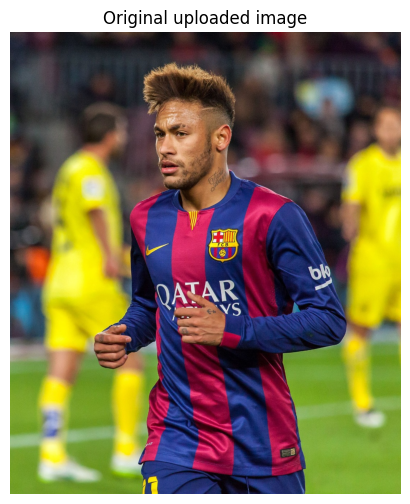

In [2]:
from google.colab import files
import matplotlib.pyplot as plt

uploaded = files.upload()
INPUT_FILENAME = list(uploaded.keys())[0]

orig = Image.open(INPUT_FILENAME).convert("RGBA")

plt.figure(figsize=(6,6))
plt.title("Original uploaded image")
plt.imshow(orig)
plt.axis("off")

Detected FULL-BODY / small head → auto portrait crop (top 65%)


(-0.5, 1080.5, 831.5, -0.5)

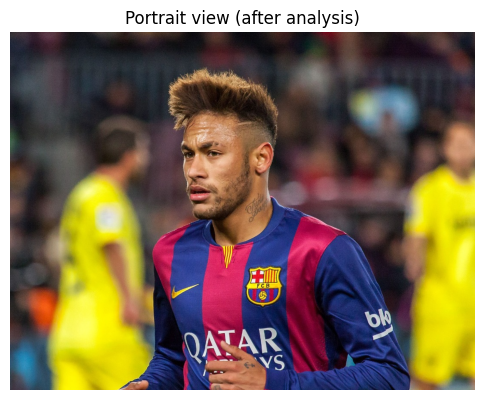

In [3]:
import mediapipe as mp
import numpy as np

mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1,
    min_detection_confidence=0.4
)

def detect_head_box(img: Image.Image):
    """Return (x, y, w, h) or None"""
    rgb = np.array(img.convert("RGB"))
    results = mp_face.process(rgb)
    if not results.detections:
        return None
    d = results.detections[0].location_data.relative_bounding_box
    W, H = img.size
    x = int(d.xmin * W)
    y = int(d.ymin * H)
    w = int(d.width * W)
    h = int(d.height * H)
    return x, y, w, h

box = detect_head_box(orig)

if box is None:
    print("⚠ No face detected → using full image as portrait")
    portrait = orig
else:
    x, y, w, h = box
    head_ratio = h / orig.height
    if head_ratio < 0.25:
        print("Detected FULL-BODY / small head → auto portrait crop (top 65%)")
        portrait = orig.crop((0, 0, orig.width, int(orig.height * 0.65)))
    else:
        print("Detected portrait / half-body → no portrait crop")
        portrait = orig

plt.figure(figsize=(6,6))
plt.title("Portrait view (after analysis)")
plt.imshow(portrait)
plt.axis("off")


(-0.5, 467.5, 467.5, -0.5)

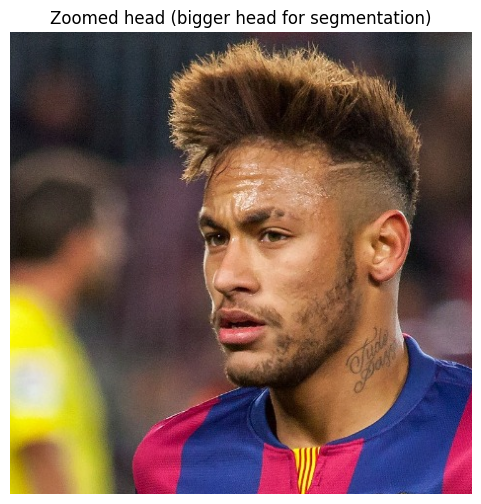

In [4]:
def zoom_head(img: Image.Image):
    """
    Return (zoomed_head_image, (x1, y1, x2, y2) in original image coords)
    We'll always detect on the ORIGINAL, not the portrait, for stability.
    """
    box = detect_head_box(orig)  # detect on original
    if box is None:
        print("⚠ No face detected → using entire portrait as zoomed head")
        return portrait, (0, 0, portrait.width, portrait.height)

    x, y, w, h = box
    pad = int(max(w, h) * 1.2)   # padding around head for hair/beard
    cx, cy = x + w//2, y + h//2

    x1 = max(cx - pad, 0)
    y1 = max(cy - pad, 0)
    x2 = min(cx + pad, orig.width)
    y2 = min(cy + pad, orig.height)

    crop = orig.crop((x1, y1, x2, y2))
    return crop, (x1, y1, x2, y2)

zoomed_head, head_bbox = zoom_head(orig)

plt.figure(figsize=(6,6))
plt.title("Zoomed head (bigger head for segmentation)")
plt.imshow(zoomed_head)
plt.axis("off")

(-0.5, 467.5, 467.5, -0.5)

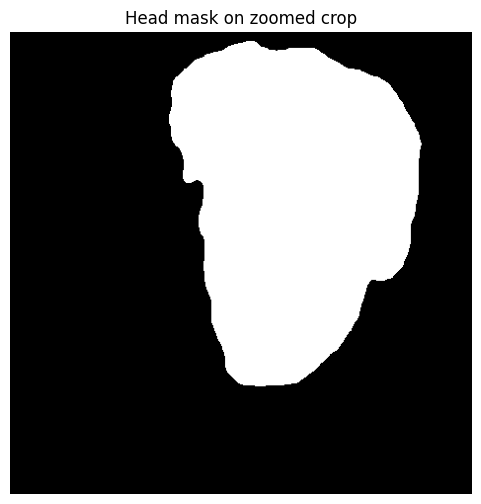

In [5]:
head_mask_crop = pipe(zoomed_head)   # this uses your exact working pipeline

plt.figure(figsize=(6,6))
plt.title("Head mask on zoomed crop")
plt.imshow(head_mask_crop, cmap="gray")
plt.axis("off")

/tmp/ipython-input-2472162029.py:21: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  head_only = Image.fromarray(orig_np, mode="RGBA")


(-0.5, 1080.5, 1279.5, -0.5)

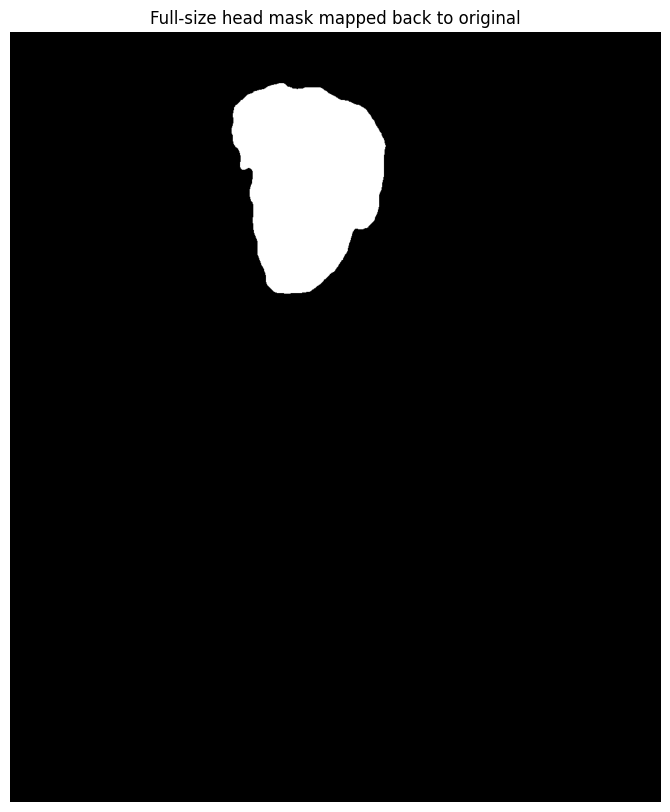

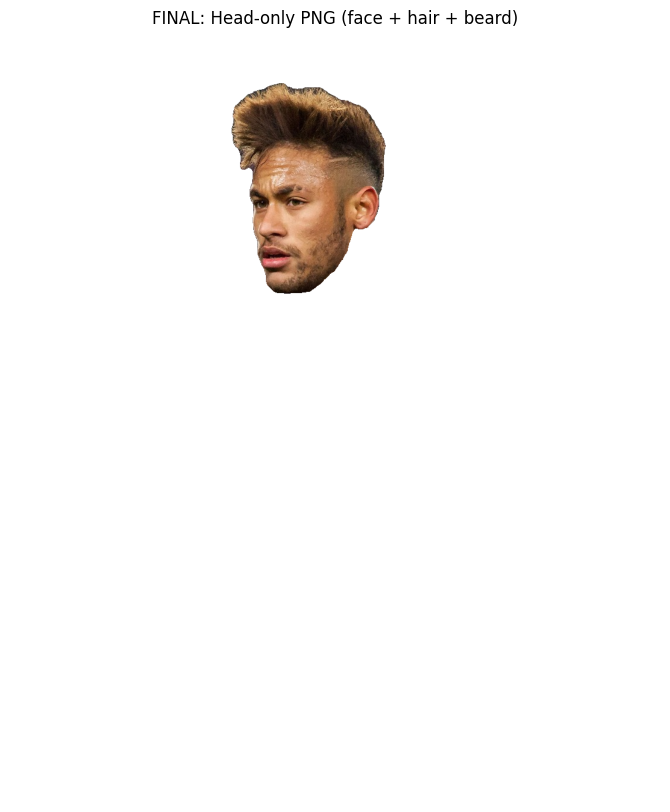

In [7]:
# Create a full-size blank mask
full_mask = Image.new("L", orig.size, 0)

x1, y1, x2, y2 = head_bbox
# resize crop mask to crop size (just in case)
head_mask_resized = head_mask_crop.resize((x2 - x1, y2 - y1), Image.Resampling.NEAREST)
full_mask.paste(head_mask_resized, (x1, y1))

plt.figure(figsize=(10,10))
plt.title("Full-size head mask mapped back to original")
plt.imshow(full_mask, cmap="gray")
plt.axis("off")

# Apply mask as alpha to original → head-only PNG
orig_np = np.array(orig)
mask_np = np.array(full_mask)

alpha = (mask_np > 128).astype(np.uint8) * 255   # binary alpha from mask
orig_np[..., 3] = alpha

head_only = Image.fromarray(orig_np, mode="RGBA")

plt.figure(figsize=(10,10))
plt.title("FINAL: Head-only PNG (face + hair + beard)")
plt.imshow(head_only)
plt.axis("off")

# head_only.save("head_only.png")
# print("Saved final head-only PNG → head_only.png")
